In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

The problem that we are trying to solve is that customers want to have a model that looks at the features of a housing unit in Oklahoma City, Oklahoma such as the number of rooms, the number of bathrooms, square footage, age, and zip code. Then, uses these features to consistently predict an accurate price for that house.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I gathered the data using the Zillow ZIP Code Search Scraper by Maximillian Copelli on console.apify.com to scrape the Zillow website for the specific information I was searching for. I entered all the zip codes in Oklahoma City, Oklahoma and selected the data I wanted the scraper to find such as number of houses, number of bathrooms, square footage, age, and zip code. Then, I ran the scraper and got about 1700 results that I will split into a training and testing data test.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


file_path_okc = "Project_2/OKC.csv"
df_okc = pd.read_csv("OKC.csv")

print(df_okc.head())

   Row_Number  addressZipcode  baths  beds    area    addressCity  \
0           1           73117    NaN   NaN     NaN  Oklahoma City   
1           2           73117    1.0   3.0  1111.0  Oklahoma City   
2           3           73117    1.0   2.0   978.0  Oklahoma City   
3           4           73117    1.0   3.0  1154.0  Oklahoma City   
4           5           73117    1.0   1.0   528.0  Oklahoma City   

   unformattedPrice  House_Age  
0             21000         36  
1             98000         49  
2             75000         44  
3             60000         40  
4             32500         37  


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

After creating different types of graph that show the relationship between individual features and the price of the house I have found multiple patterns. Using correlation heatmaps I've found that square footage has the strongest positive correlation with price, baths had a moderate positive correlation with price, and beds had a weaker positive correlation with price. Using scatterplots I've discovered that price vs. area has a clear upward trend as prices rise steadily with square footage, price vs beds have a upward trend with a lot of scatter, and price vs beds had a clearer upward slope as adding bathrooms adds value consistently. Using boxplots by Zip Code I have discovered that some zip codes have a significantly higher median price than others, which shows that location is a key factor.

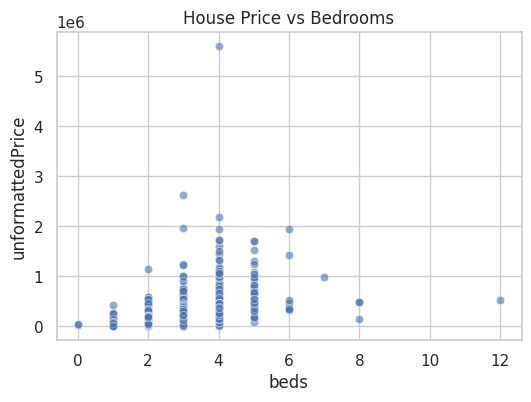

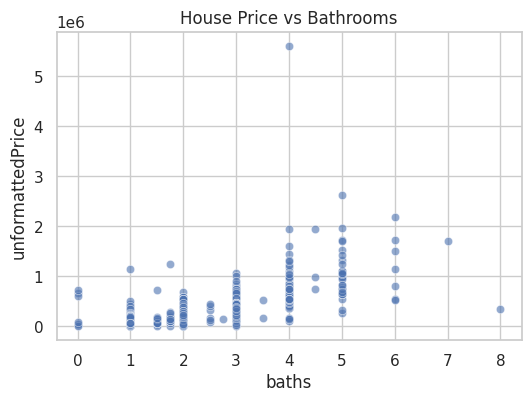

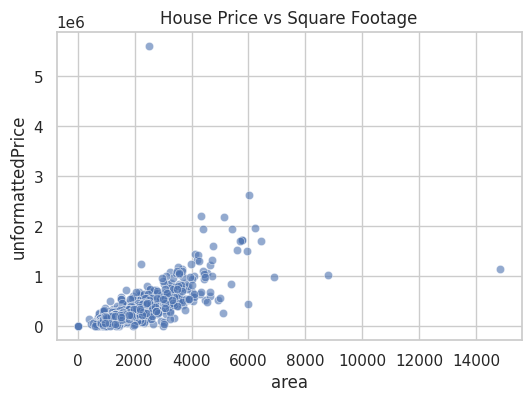

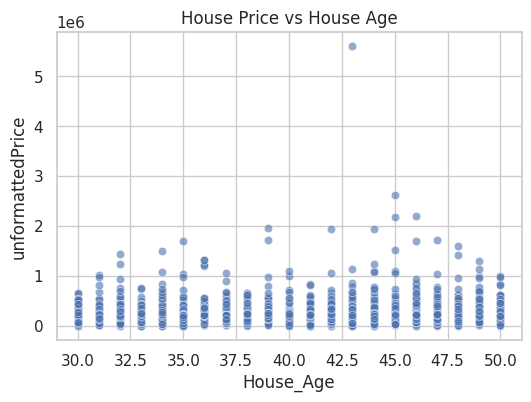

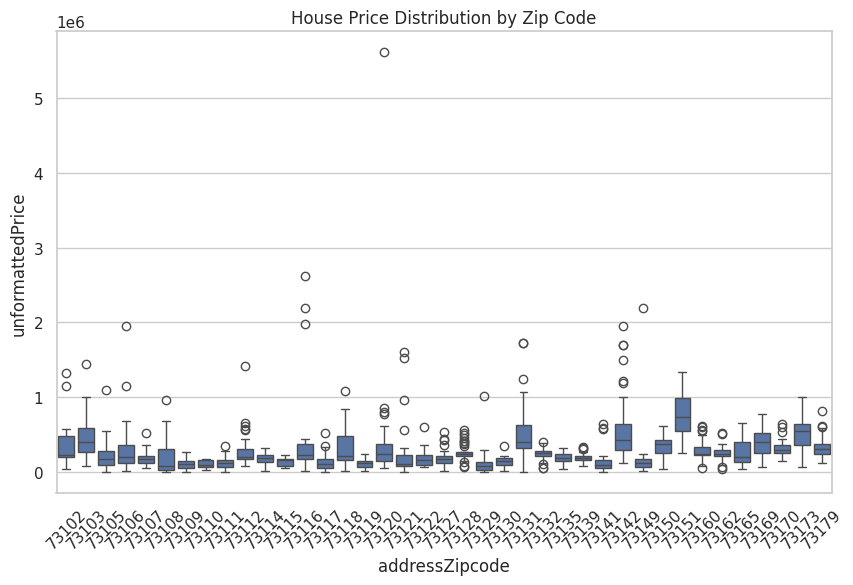

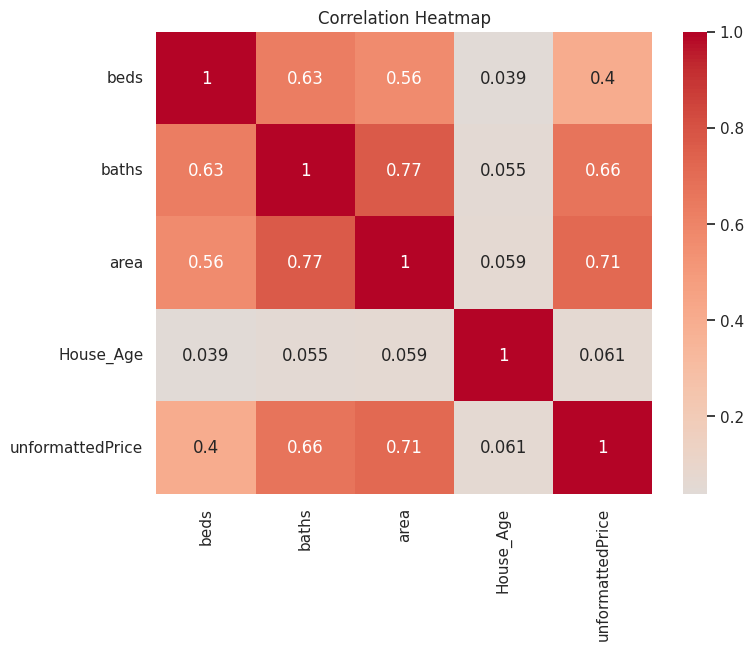

In [2]:
sns.set(style="whitegrid")

# Scatterplots
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_okc, x="beds", y="unformattedPrice", alpha=0.6)
plt.title("House Price vs Bedrooms")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df_okc, x="baths", y="unformattedPrice", alpha=0.6)
plt.title("House Price vs Bathrooms")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df_okc, x="area", y="unformattedPrice", alpha=0.6)
plt.title("House Price vs Square Footage")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df_okc, x="House_Age", y="unformattedPrice", alpha=0.6)
plt.title("House Price vs House Age")
plt.show()

# Boxplot by Zip Code
plt.figure(figsize=(10,6))
sns.boxplot(data=df_okc, x="addressZipcode", y="unformattedPrice")
plt.xticks(rotation=45)
plt.title("House Price Distribution by Zip Code")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8,6))
corr = df_okc[["beds","baths","area","House_Age","unformattedPrice"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


I checked for any missing values in each row and dropped the whole row if there was any missing values. Then, I removed outliers in housing prices using Tukey's rule, since unusually high or low values could mess with the model's learning. To account for the previously seen variance by zip code I replaced them with the average house price in each zip code, allowing the model to recognize location based patterns. I also applied a log transformation to the area to reduce skews caused by very large homes and make the relationship between size and price balanced. Finally, I created a clean dataset with the most relevant features: bedrooms, bathrooms, area, and zip code. I also included the price as the target variable.

In [3]:
# Drop missing
df_okc = df_okc.dropna(subset=["unformattedPrice", "beds", "baths", "area", "addressZipcode"])

# Outlier removal
Q1 = df_okc["unformattedPrice"].quantile(0.25)
Q3 = df_okc["unformattedPrice"].quantile(0.75)
IQR = Q3 - Q1
df_okc = df_okc[(df_okc["unformattedPrice"] >= Q1 - 1.5*IQR) &
                (df_okc["unformattedPrice"] <= Q3 + 1.5*IQR)]

# Encode zipcodes
zip_mean_price = df_okc.groupby("addressZipcode")["unformattedPrice"].mean()
df_okc["zipcode_encoded"] = df_okc["addressZipcode"].map(zip_mean_price)

# Log-transform area
df_okc["log_area"] = np.log1p(df_okc["area"])

# Final dataset
df_model = df_okc[["beds", "baths", "log_area", "zipcode_encoded", "unformattedPrice"]]


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


First, I split the dataset into training and testing sets, with 80% for training and 20% for testing. Since the features contained variables with different scales, I applied standard scaling to normalize the data, which helps the model weigh each feature fairly. For the model my first experiment I used Random Forest, which worked pretty well, so I didn't have to experiment with any other moddles. Then I trained it on the training data.

In [4]:
# Train/Test split
X = df_model.drop("unformattedPrice", axis=1)
y = df_model["unformattedPrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(max_features='sqrt', n_estimators=1200, n_jobs=-1,
                      random_state=42)

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


To fine tune the model I checked its performance with the R^2 score and the Root Mean Squared error. The R2 score is basically like an accuracy rate as it explains the variation in house prices, with values closer to 1 indicating stronger predictive power. RMSE shows the average prediction error in dollars, giving me a sense of how far off the model is from real prices. I used these prediction to see if the model was performing well or needed work. At the end I got to an accuracy rate of 75%. 

In [5]:
y_pred = rf_model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 Score: {round(r2, 3)}")
print(f"RMSE: ${round(rmse, 2):,.0f}")

R2 Score: 0.75
RMSE: $66,632


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


The objective was to predict housing prices in Oklahoma City based on features such as bedrooms, bathrooms, square footage, andzip code. I began by carefully cleaning the data to remove missing values and outliers, then applied transformations such as log-scaling area and encoding zip codes by their average prices to improve model accuracy. The Random Forest model was used because it has strong performance and ability to handle complex patterns in the data. Our evaluation showed that the model achieved a strong R^2 score of 0.75, meaning my model was had an accuracy rate of 0.75, and a relatively low RMSE, showing that average errors in predictions were within a reasonable dollar range. These results demonstrate that the system can provide reliable price estimates for homes given their characteristics, offering practical value for customers looking to see the predicted price of homes with different features.

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [6]:
def inference(params):
    """
    params:
        - beds
        - baths
        - area
        - addressZipcode
    """
    # Convert to DataFrame
    input_df = pd.DataFrame([params])

    # Encode zipcode with mean price mapping (same as training)
    input_df["zipcode_encoded"] = input_df["addressZipcode"].map(zip_mean_price)

    # Log-transform area
    input_df["log_area"] = np.log1p(input_df["area"])

    # Final feature set (same order as training)
    X_new = input_df[["beds", "baths", "log_area", "zipcode_encoded"]]

    # Scale features
    X_new_scaled = scaler.transform(X_new)

    # Predict
    predicted_price = rf_model.predict(X_new_scaled)[0]

    return predicted_price

house = {
    "beds": 3,
    "baths": 2,
    "area": 1800,
    "addressZipcode": 73120
}

print("Predicted Price: $", round(inference(house), 2))


Predicted Price: $ 271954.9
